<a href="https://colab.research.google.com/github/7sr7/Intro-to-AI-HW4/blob/main/Silvestre_Intro_to_AI_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 4: Spatial Attention for CNNs

### 20 points + up to 30 extra credit

##### Due: Tuesday. August 12th (11:59pm)

In this assignment you will extend your convolutional neural network from Homework 3 by adding an attention mechanism. We will start with the same dataset as before (MNIST) and work our way up to new datasets.

You may download this assignment as a Jupyter notebook file from Submitty.

**Note:** This assignent is more focused on theoretical understanding and analysis than results. If you are able to achieve good results, you are eligible for up to 30 points of extra credit (towards your homework score, which is 35% of your grade; in other words, you can earn up to 10 points on your overall score by fully completing the extra credit portion). However, **your attention model does not need to outperform your CNN** in order to earn full credit.

#### Provided utility code

These functions load various image datasets. MNIST is the smallest/simplest, FashionMNIST is somewhat more complex, CIFAR10 is more complex than that, and CIFAR100 is the largest.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)

### Dataset loader utility functions ###

def get_dataset(name, batch_size=64):
    if name == "MNIST":
        mean, std = (0.1307,), (0.3081,)
        in_channels, image_size, num_classes = 1, 28, 10
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        dataset_cls = datasets.MNIST

    elif name == "FashionMNIST":
        mean, std = (0.2860,), (0.3530,)
        in_channels, image_size, num_classes = 1, 28, 10
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        dataset_cls = datasets.FashionMNIST

    elif name == "CIFAR10":
        mean = [0.4914, 0.4822, 0.4465]
        std =  [0.2470, 0.2435, 0.2616]
        in_channels, image_size, num_classes = 3, 32, 10
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        dataset_cls = datasets.CIFAR10

    elif name == "CIFAR100":
        mean = [0.5071, 0.4867, 0.4408]
        std =  [0.2675, 0.2565, 0.2761]
        in_channels, image_size, num_classes = 3, 32, 100
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        dataset_cls = datasets.CIFAR100

    else:
        raise ValueError(f"Unknown dataset: {name}")

    train_raw = dataset_cls(root="./data", train=True, download=True, transform=transform)
    test_raw  = dataset_cls(root="./data", train=False, download=True, transform=transform)

    train_data, val_data = random_split(train_raw, [int(0.9 * len(train_raw)), len(train_raw) - int(0.9 * len(train_raw))],
                                        generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_data, batch_size=batch_size)
    test_loader  = DataLoader(test_raw, batch_size=batch_size)

    return train_loader, val_loader, test_loader, in_channels, image_size, num_classes

### Training / Evaluation utility functions ###

def train_one_epoch(model, train_loader, val_loader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)

    # Run validation immediately after each epoch
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    return avg_loss, accuracy, val_loss, val_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy


## Part 1: Attention

### (10 points)

#### Baseline CNN

To start, we'll use the CNN you created from HW3 -- modified slightly. We've provided a "dummy" CNN to show how you might modify your original CNN -- essentially, you are using the hidden layers you created, but not the final steps of compressing them into an output. This is because we will need that information in order to implement attention!

Paste the PyTorch class defining your best performing CNN from Homework 3 here. Make sure the network returns a feature map (not flattened) so that you can apply attention over the spatial dimensions. If your original model flattened the tensor before the classifier, separate the convolutional part from the classifier so you can access the feature map.

It is recoemmended that your CNN outptu an unflattened tensor of shape \[B, C, H, W\]:
- B: the batch size: how many examples are processed together in one forward/backward pass.
- C: the number of channels: for raw images this is 1 for grayscale or 3 for RGB, and for intermediate feature maps it’s the number of filters output by a convolution layer.
- H: the height of each image or feature map, in pixels.
- W: the width of each image or feature map, in pixels.

In [ ]:


# class BaseCNN(nn.Module):
#     def __init__(self, in_channels=1):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)  # You may choose to apply only once, or not at all

#     def forward(self, x):
#         x = F.relu(self.conv1(x))  # [B, 32, H, W]
#         x = F.relu(self.conv2(x))  # [B, 64, H, W]
#         x = self.pool(x)           # [B, 64, H/2, W/2] (optional)
#         return x


In [ ]:
# TODO: Replace this dummy CNN with your Homework 3 model.
# IMPORTANT: Modify your model to:
#  (1) Remove flattening and FC layers
#  (2) Return [B, C, H, W] feature maps
#  B - Number of batches
#  (3) Preserve enough spatial resolution (avoid aggressive pooling)

# fo1llowing the instructions, i have implemented my best CNN from hw3...
# it just so happens to be very similar to the baseCNN that was given...
class BaseCNN(nn.Module):
  def __init__(self, in_channels=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, 32, 3, stride = 1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, stride = 1, padding=1)

    self.dropout = nn.Dropout(0.5)
    self.conv_dropout = nn.Dropout2d(0.2)

    self.pool = nn.MaxPool2d(2, 2)


  def forward(self, x):
    # [B, in_channels, H, W] --> [B, 32, H/2, W/2]
    x = self.pool(F.relu(self.conv1(x)))
    x = self.conv_dropout(x)


    # might take out the last pooling if i think its a problem...
    # [B, 32, H/2, W/2] --> [B, 64, H/4, W/4]
    x = self.pool(F.relu(self.conv2(x)))
    x = self.conv_dropout(x)

    return x

#### Fully connected (FC) CNN

This CNN uses the BaseCNN in a standard fully connected neural net to compute results. We'll just use it for comparison, and you can also use it to confirm your BaseCNN implementation is correct.

In [ ]:
class FCClassifier(nn.Module):
    def __init__(self, base_cnn, feature_shape=(64, 14, 14),num_classes=10):
        super().__init__()
        self.base = base_cnn
        C, H, W = feature_shape
        self.fc1 = nn.Linear(C * H * W, 128)
        self.out = nn.Linear(128, num_classes)

    def forward(self, x):
        feats = self.base(x)                  # [B, C, H, W]
        flat = feats.view(x.size(0), -1)      # [B, C*H*W]
        x = F.relu(self.fc1(flat))
        return self.out(x)


#### Spatial Attention

The code below defines a new network, AttentionCNN, which adds an attention mechanism and additional layers to BaseCNN.

Your task is to replace the "dummy" attention implementation below with your own attention function (the dummy function assigns all attention scores as equal to one). In additon, you will likely need to add additional layers to the network, or adjust it as needed.

To start, we recommend a simple attention mechanism: Compute attention scores by taking the average over all channels in the flattened input features (the matrix "flat"). We'll be modifying this to add more complex attention mechanisms as we go, however.

In [ ]:
class AttentionCNN(nn.Module):
    def __init__(self, base_cnn, feature_shape, num_classes=10):
        super().__init__()

        # By default: first "layer" is base_cnn, then it computes attention
        self.base_cnn = base_cnn
        C, H, W = feature_shape


        # after attention is computed: uses a couple more layers
        # take in only C since agg is of dim [B,C]...
        self.fc1 = nn.Linear(C, 128)
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(128, num_classes)


    def forward(self, x):
        # Pass the input through the base CNN to extract feature maps
        # Shape: [B, C, H, W]
        feats = self.base_cnn(x)


        # Unpack dimensions for clarity
        B, C, H, W = feats.shape


        # Flatten the spatial dimensions (H and W) into a single dimension
        # This treats each spatial position as a separate "token" for attention
        flat = feats.view(B, C, H * W) # [B, C, H*W]


        # calculating attention...
        if False:
            attn_scores = torch.ones(B, H * W, device=feats.device) # [B, H*W]

        else:
            # take the average over all channels...
            attn_scores = flat.mean(dim=1)

            # Apply softmax to obtain normalized attention weights
            # Because all scores are equal, softmax will output uniform weights
            attn_weights = torch.softmax(attn_scores, dim=1) # [B, H*W]

            # Apply attention weights to the feature map
            # First, expand attn_weights to [B, 1, H*W] to match flat's shape for broadcasting
            weighted = flat * attn_weights.unsqueeze(1) # [B, C, H*W]

            # Aggregate (sum) over the spatial dimension to get a global feature vector per sample
            # Since weights are uniform, this is equivalent to average pooling over spatial positions
            agg = weighted.sum(dim=2) # [B, C]


        x = F.relu(self.fc1(agg))
        x = self.dropout(x)
        return self.out(x)


#### Training and testing

Evaluate your AttentionCNN on MNIST, and compare it to the basic FCClassifier. What do you see? USe Use matplotlib to visualize the training loss and validation accuracy across epochs for both of the models. This will help you see whether the models are improving, and whether they have started to overfit.

(Don't expect AttentionCNN to outperform the FC  model here unless you've added a very complex attention mechanism! This dataset is simple enough that attention may not add as much value as you might expect.)

In [ ]:
# Use the utility functions to load the MNIST dataset, train, and test.
# We've shown how to use them with FCClassifier below.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST and get dataset info
train_loader, val_loader, test_loader, in_channels, image_size, num_classes = get_dataset("MNIST",batch_size=64)
criterion = nn.CrossEntropyLoss()

# Instantiate base feature extractor
base_model = BaseCNN(in_channels=in_channels).to(device)

# Train FC baseline
print("Training Fully Connected Baseline...")
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []


fc_model = FCClassifier(base_model, feature_shape=(64, image_size // 4, image_size // 4), num_classes=num_classes).to(device)
fc_optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)

for epoch in range(1, 6):
    tr_loss, tr_acc, val_loss, val_acc = train_one_epoch(fc_model, train_loader, val_loader, fc_optimizer, criterion, device)
    print(f"[FC] Epoch {epoch}: Train Acc = {tr_acc:.4f}, Val Acc = {val_acc:.4f}")

    # for plotting...
    train_losses.append(tr_loss)
    val_losses.append(val_loss)

    train_accuracies.append(tr_acc)
    val_accuracies.append(val_acc)

test_loss, test_acc = evaluate(fc_model, test_loader, criterion, device)
print(f"[FC] Test Accuracy = {test_acc:.4f}")


Training Fully Connected Baseline...
[FC] Epoch 1: Train Acc = 0.9470, Val Acc = 0.9812
[FC] Epoch 2: Train Acc = 0.9814, Val Acc = 0.9830
[FC] Epoch 3: Train Acc = 0.9863, Val Acc = 0.9873
[FC] Epoch 4: Train Acc = 0.9889, Val Acc = 0.9880
[FC] Epoch 5: Train Acc = 0.9911, Val Acc = 0.9890
[FC] Test Accuracy = 0.9915


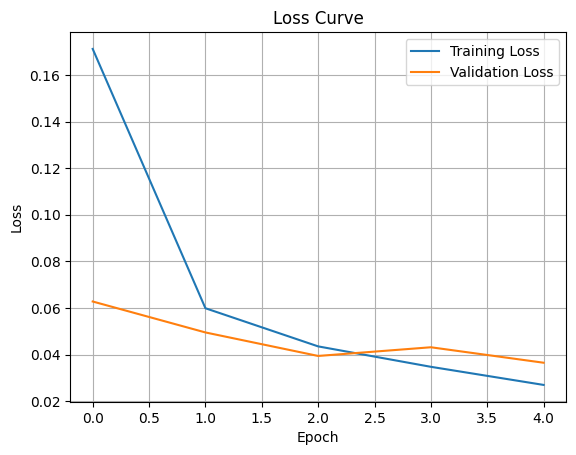

In [ ]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

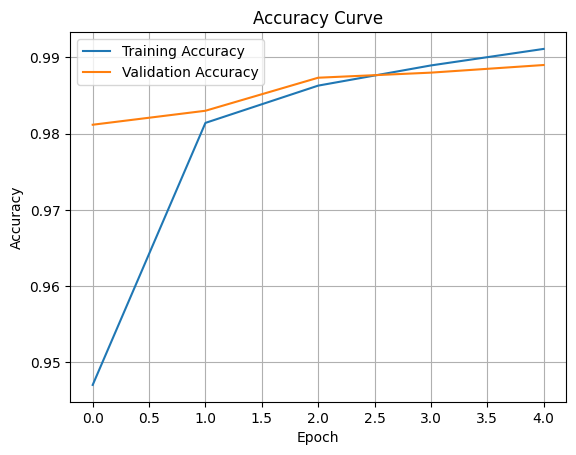

In [ ]:
# plotting accuracy...
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST and get dataset info
train_loader, val_loader, test_loader, in_channels, image_size, num_classes = get_dataset("MNIST",batch_size=64)
criterion = nn.CrossEntropyLoss()

# Instantiate base feature extractor
base_model = BaseCNN(in_channels=in_channels).to(device)

print("Training Attention CNN...")
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []


att_model = AttentionCNN(base_model, feature_shape=(64, image_size // 4, image_size // 4), num_classes=num_classes).to(device)
att_optimizer = torch.optim.Adam(att_model.parameters(), lr=0.001)

for epoch in range(1, 6):
    tr_loss, tr_acc, val_loss, val_acc = train_one_epoch(att_model, train_loader, val_loader, att_optimizer, criterion, device)
    print(f"[AttCNN] Epoch {epoch}: Train Acc = {tr_acc:.4f}, Val Acc = {val_acc:.4f}")

    # for plotting...
    train_losses.append(tr_loss)
    val_losses.append(val_loss)

    train_accuracies.append(tr_acc)
    val_accuracies.append(val_acc)

test_loss, test_acc = evaluate(att_model, test_loader, criterion, device)
print(f"[AttCNN] Test Accuracy = {test_acc:.4f}")


Training Attention CNN...
[AttCNN] Epoch 1: Train Acc = 0.4068, Val Acc = 0.7518
[AttCNN] Epoch 2: Train Acc = 0.7464, Val Acc = 0.8998
[AttCNN] Epoch 3: Train Acc = 0.8414, Val Acc = 0.9322
[AttCNN] Epoch 4: Train Acc = 0.8811, Val Acc = 0.9418
[AttCNN] Epoch 5: Train Acc = 0.9008, Val Acc = 0.9508
[AttCNN] Test Accuracy = 0.9575


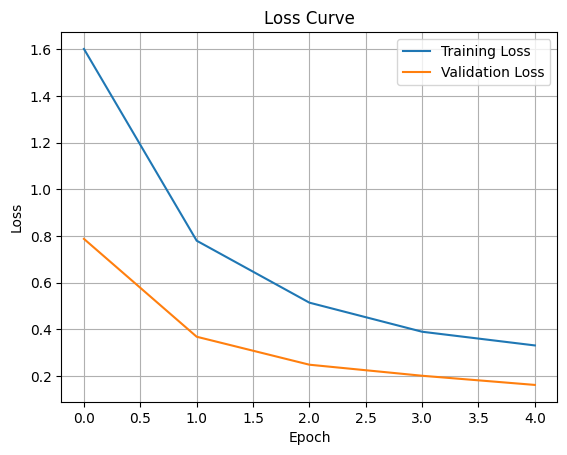

In [ ]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

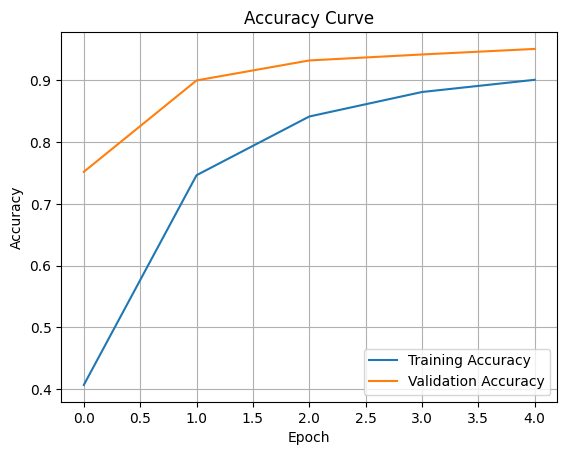

In [ ]:
# plotting accuracy...
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)
plt.show()

For this part of the assignment, the attention I had used for computation is the average over all the channels.
Strictly from looking at the graphs of loss and accuracy for both training and validation, I observe that the model
is actually learning and with no signs of overfitting yet, which is good.

When comparing to the basic FCClassifier, the AttentionCNN is less accurate, with a test set accuracy of ~96%,
while FCClassifier has a ~99% accuracy. This is a noticeable difference, and I believe that one reason for this
difference is, as said in the directions, MNIST is too basic for attention to have a more noticeable effect.

#### Visualize the attention weights

To confirm that your attention weights correspond to the most salient parts of the image, pick a few examples from the test set and visualize their attention maps. Overlay the attention weights on the input image to see which pixels the model focuses on. Hint: you can obtain the attention weights by copying the code from your forward method and applying it to one image.

See here for an example of what a correct attention map looks like: [hw4-example-attention-map.png](https://submitty.cs.rpi.edu/courses/u25/csci4150/course_material/Homework/Homework%204/hw4-example-attention-map.png).

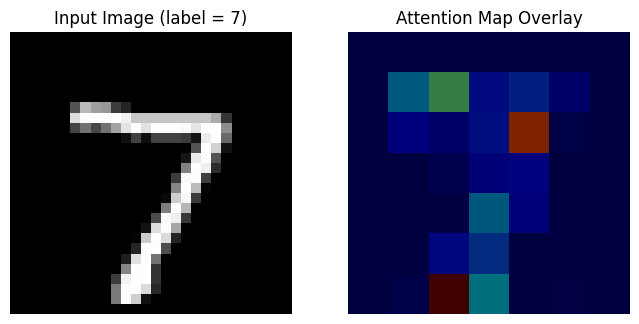

In [ ]:
# visualizing attention weights...
model = att_model

model.eval()
with torch.no_grad():
    sample_img, sample_label = test_loader.dataset[0]
    sample_tensor = sample_img.unsqueeze(0).to(device)
    # Get feature map from the base CNN
    feats = att_model.base_cnn(sample_tensor)
    B, C, H, W = feats.shape
    flat = feats.view(B, C, H * W) # [B, C, H*W]


    # calculating attention...
    if False:
        attn_scores = torch.ones(B, H * W, device=feats.device) # [B, H*W]
    else:
        attn_scores = flat.mean(dim=1)

    # Apply softmax to obtain normalized attention weights
    # Because all scores are equal, softmax will output uniform weights
    attn_weights = torch.softmax(attn_scores, dim=1) # [B, H*W]

    attn_map = attn_weights.view(H, W).cpu().numpy()
    # Normalize attention map for better visualization
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    # Plot input image
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(sample_img.squeeze(0), cmap='gray')
    ax[0].set_title(f'Input Image (label = {sample_label})')
    ax[0].axis('off')
    # Plot attention map overlay
    ax[1].imshow(sample_img.squeeze(0), cmap='gray')
    ax[1].imshow(attn_map, cmap='jet', alpha=0.5)
    ax[1].set_title('Attention Map Overlay')
    ax[1].axis('off')

## Part 2: Testing and iteration

### (10 points)

As you might expect, attention doesn't make a huge difference for a small dataset like MNIST. Try running the other three datasets: Fashion‑MNIST, CIFAR10, and CIFAR100.

For each dataset:
- Run both the baseline fully connected model and the simple attention model
- Visualize the attention weights
- Answer the questions below

### Fashion-MNIST Testing...

#### FCClassifier Testing...

Test Accuracy: .9095

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST and get dataset info
train_loader, val_loader, test_loader, in_channels, image_size, num_classes = get_dataset("FashionMNIST",batch_size=64)
criterion = nn.CrossEntropyLoss()

# Instantiate base feature extractor
base_model = BaseCNN(in_channels=in_channels).to(device)

# Train FC baseline
print("Training Fully Connected Baseline...")
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []


fc_model = FCClassifier(base_model, feature_shape=(64, image_size // 4, image_size // 4), num_classes=num_classes).to(device)
fc_optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)

for epoch in range(1, 6):
    tr_loss, tr_acc, val_loss, val_acc = train_one_epoch(fc_model, train_loader, val_loader, fc_optimizer, criterion, device)
    print(f"[FC] Epoch {epoch}: Train Acc = {tr_acc:.4f}, Val Acc = {val_acc:.4f}")

    # for plotting...
    train_losses.append(tr_loss)
    val_losses.append(val_loss)

    train_accuracies.append(tr_acc)
    val_accuracies.append(val_acc)

test_loss, test_acc = evaluate(fc_model, test_loader, criterion, device)
print(f"[FC] Test Accuracy = {test_acc:.4f}")


100%|██████████| 26421880/26421880 [00:01<00:00, 16739573.01it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 294413.95it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5225947.47it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 4100318.46it/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

Training Fully Connected Baseline...
[FC] Epoch 1: Train Acc = 0.8306, Val Acc = 0.8847
[FC] Epoch 2: Train Acc = 0.8857, Val Acc = 0.8982
[FC] Epoch 3: Train Acc = 0.9019, Val Acc = 0.9050
[FC] Epoch 4: Train Acc = 0.9133, Val Acc = 0.9125
[FC] Epoch 5: Train Acc = 0.9194, Val Acc = 0.9185
[FC] Test Accuracy = 0.9095


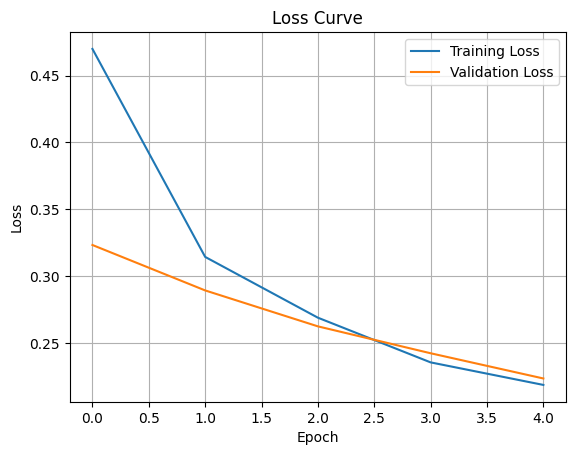

In [ ]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

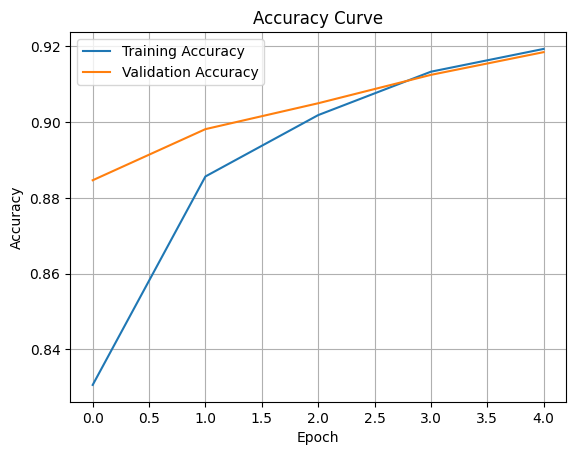

In [ ]:
# plotting accuracy...
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)
plt.show()

#### AttentionCNN testing...

Test Accuracy: .8137

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST and get dataset info
train_loader, val_loader, test_loader, in_channels, image_size, num_classes = get_dataset("FashionMNIST",batch_size=64)
criterion = nn.CrossEntropyLoss()

# Instantiate base feature extractor
base_model = BaseCNN(in_channels=in_channels).to(device)

print("Training Attention CNN...")
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []


att_model = AttentionCNN(base_model, feature_shape=(64, image_size // 4, image_size // 4), num_classes=num_classes).to(device)
att_optimizer = torch.optim.Adam(att_model.parameters(), lr=0.001)

for epoch in range(1, 6):
    tr_loss, tr_acc, val_loss, val_acc = train_one_epoch(att_model, train_loader, val_loader, att_optimizer, criterion, device)
    print(f"[AttCNN] Epoch {epoch}: Train Acc = {tr_acc:.4f}, Val Acc = {val_acc:.4f}")

    # for plotting...
    train_losses.append(tr_loss)
    val_losses.append(val_loss)

    train_accuracies.append(tr_acc)
    val_accuracies.append(val_acc)

test_loss, test_acc = evaluate(att_model, test_loader, criterion, device)
print(f"[AttCNN] Test Accuracy = {test_acc:.4f}")


Training Attention CNN...
[AttCNN] Epoch 1: Train Acc = 0.4951, Val Acc = 0.7045
[AttCNN] Epoch 2: Train Acc = 0.6651, Val Acc = 0.7480
[AttCNN] Epoch 3: Train Acc = 0.7143, Val Acc = 0.7617
[AttCNN] Epoch 4: Train Acc = 0.7405, Val Acc = 0.7922
[AttCNN] Epoch 5: Train Acc = 0.7612, Val Acc = 0.8128
[AttCNN] Test Accuracy = 0.8137


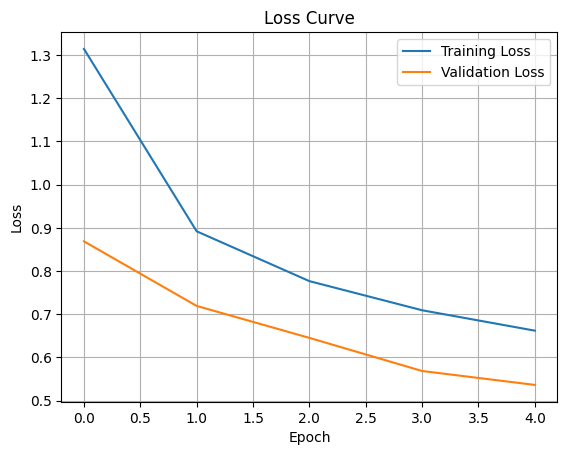

In [ ]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

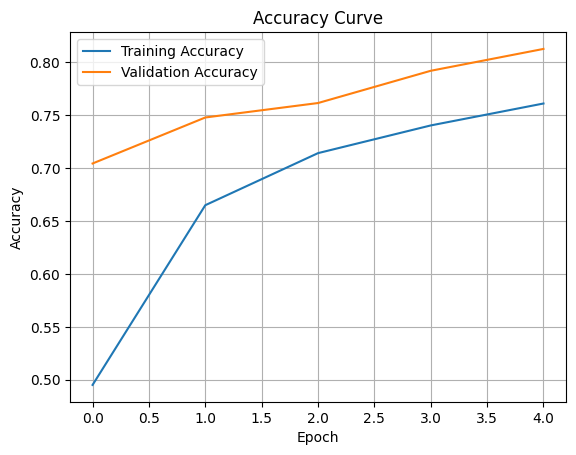

In [ ]:
# plotting accuracy...
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)
plt.show()

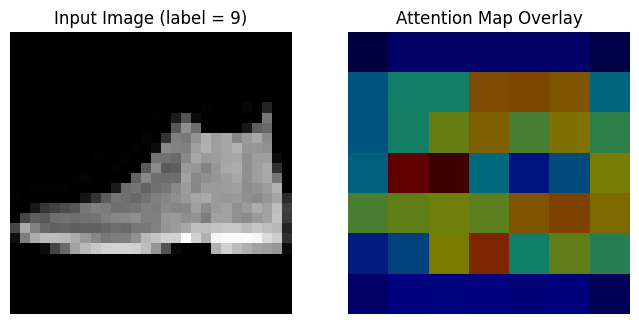

In [ ]:
# visualizing attention weights...
model = att_model

model.eval()
with torch.no_grad():
    sample_img, sample_label = test_loader.dataset[0]
    sample_tensor = sample_img.unsqueeze(0).to(device)
    # Get feature map from the base CNN
    feats = att_model.base_cnn(sample_tensor)
    B, C, H, W = feats.shape
    flat = feats.view(B, C, H * W) # [B, C, H*W]


    # calculating attention...
    if False:
        attn_scores = torch.ones(B, H * W, device=feats.device) # [B, H*W]
    else:
        attn_scores = flat.mean(dim=1)

    # Apply softmax to obtain normalized attention weights
    # Because all scores are equal, softmax will output uniform weights
    attn_weights = torch.softmax(attn_scores, dim=1) # [B, H*W]

    attn_map = attn_weights.view(H, W).cpu().numpy()
    # Normalize attention map for better visualization
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    # Plot input image
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(sample_img.squeeze(0), cmap='gray')
    ax[0].set_title(f'Input Image (label = {sample_label})')
    ax[0].axis('off')
    # Plot attention map overlay
    ax[1].imshow(sample_img.squeeze(0), cmap='gray')
    ax[1].imshow(attn_map, cmap='jet', alpha=0.5)
    ax[1].set_title('Attention Map Overlay')
    ax[1].axis('off')

### CIFAR10 Testing...

#### FCClassifier Testing...

Test Accuracy: .6985

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST and get dataset info
train_loader, val_loader, test_loader, in_channels, image_size, num_classes = get_dataset("CIFAR10",batch_size=64)
criterion = nn.CrossEntropyLoss()

# Instantiate base feature extractor
base_model = BaseCNN(in_channels=in_channels).to(device)

# Train FC baseline
print("Training Fully Connected Baseline...")
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []


fc_model = FCClassifier(base_model, feature_shape=(64, image_size // 4, image_size // 4), num_classes=num_classes).to(device)
fc_optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)

for epoch in range(1, 6):
    tr_loss, tr_acc, val_loss, val_acc = train_one_epoch(fc_model, train_loader, val_loader, fc_optimizer, criterion, device)
    print(f"[FC] Epoch {epoch}: Train Acc = {tr_acc:.4f}, Val Acc = {val_acc:.4f}")

    # for plotting...
    train_losses.append(tr_loss)
    val_losses.append(val_loss)

    train_accuracies.append(tr_acc)
    val_accuracies.append(val_acc)

test_loss, test_acc = evaluate(fc_model, test_loader, criterion, device)
print(f"[FC] Test Accuracy = {test_acc:.4f}")


100%|██████████| 170498071/170498071 [00:03<00:00, 56654894.57it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training Fully Connected Baseline...
[FC] Epoch 1: Train Acc = 0.4710, Val Acc = 0.5918
[FC] Epoch 2: Train Acc = 0.5993, Val Acc = 0.6420
[FC] Epoch 3: Train Acc = 0.6475, Val Acc = 0.6756
[FC] Epoch 4: Train Acc = 0.6766, Val Acc = 0.6910
[FC] Epoch 5: Train Acc = 0.6993, Val Acc = 0.7098
[FC] Test Accuracy = 0.6985


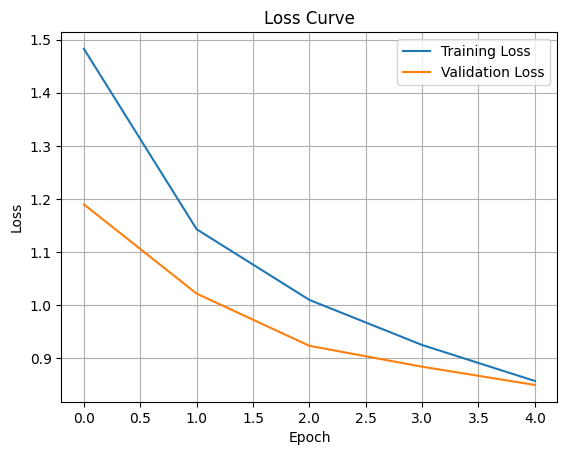

In [ ]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

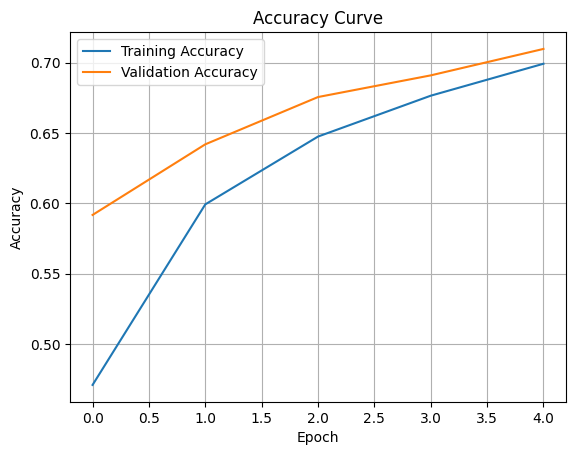

In [ ]:
# plotting accuracy...
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)
plt.show()

#### AttentionCNN Testing...

Test Accuracy: .4903

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST and get dataset info
train_loader, val_loader, test_loader, in_channels, image_size, num_classes = get_dataset("CIFAR10",batch_size=64)
criterion = nn.CrossEntropyLoss()

# Instantiate base feature extractor
base_model = BaseCNN(in_channels=in_channels).to(device)

print("Training Attention CNN...")
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []


att_model = AttentionCNN(base_model, feature_shape=(64, image_size // 4, image_size // 4), num_classes=num_classes).to(device)
att_optimizer = torch.optim.Adam(att_model.parameters(), lr=0.001)

for epoch in range(1, 6):
    tr_loss, tr_acc, val_loss, val_acc = train_one_epoch(att_model, train_loader, val_loader, att_optimizer, criterion, device)
    print(f"[AttCNN] Epoch {epoch}: Train Acc = {tr_acc:.4f}, Val Acc = {val_acc:.4f}")

    # for plotting...
    train_losses.append(tr_loss)
    val_losses.append(val_loss)

    train_accuracies.append(tr_acc)
    val_accuracies.append(val_acc)

test_loss, test_acc = evaluate(att_model, test_loader, criterion, device)
print(f"[AttCNN] Test Accuracy = {test_acc:.4f}")


Files already downloaded and verified
Files already downloaded and verified
Training Attention CNN...
[AttCNN] Epoch 1: Train Acc = 0.2471, Val Acc = 0.3596
[AttCNN] Epoch 2: Train Acc = 0.3355, Val Acc = 0.4110
[AttCNN] Epoch 3: Train Acc = 0.3777, Val Acc = 0.4360
[AttCNN] Epoch 4: Train Acc = 0.4055, Val Acc = 0.4744
[AttCNN] Epoch 5: Train Acc = 0.4256, Val Acc = 0.4870
[AttCNN] Test Accuracy = 0.4903


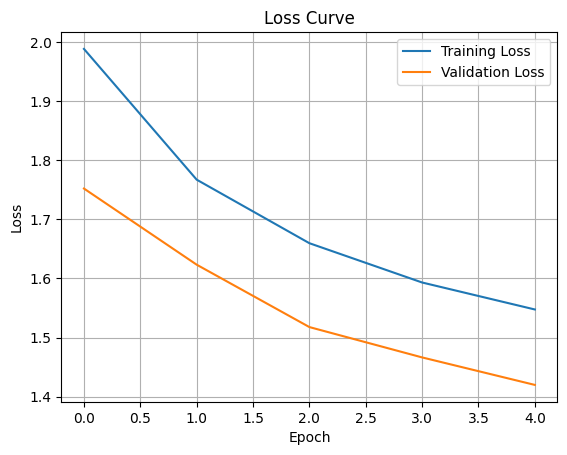

In [ ]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

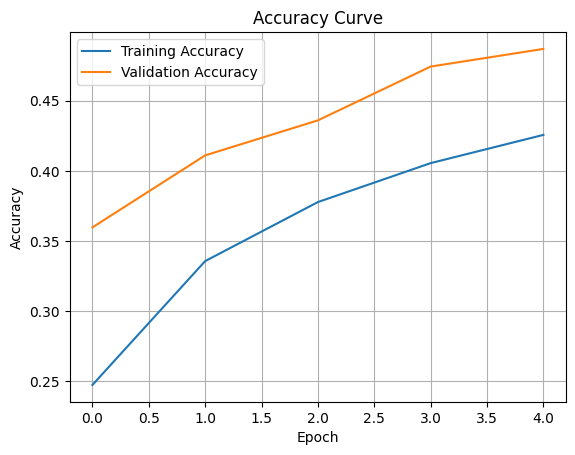

In [ ]:
# plotting accuracy...
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)
plt.show()

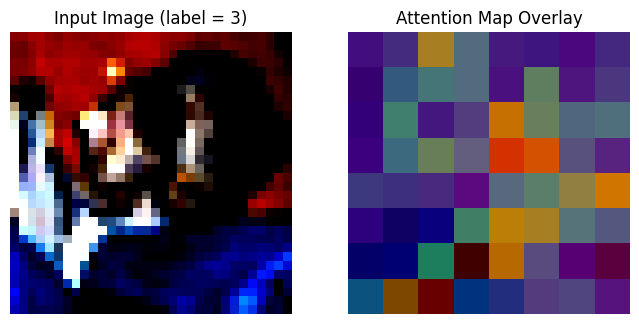

In [ ]:
# visualizing attention weights...
model = att_model

model.eval()
with torch.no_grad():
    sample_img, sample_label = test_loader.dataset[0]
    sample_tensor = sample_img.unsqueeze(0).to(device)
    # Get feature map from the base CNN
    feats = att_model.base_cnn(sample_tensor)
    B, C, H, W = feats.shape
    flat = feats.view(B, C, H * W) # [B, C, H*W]


    # calculating attention...
    if False:
        attn_scores = torch.ones(B, H * W, device=feats.device) # [B, H*W]
    else:
        attn_scores = flat.mean(dim=1)

    # Apply softmax to obtain normalized attention weights
    # Because all scores are equal, softmax will output uniform weights
    attn_weights = torch.softmax(attn_scores, dim=1) # [B, H*W]

    attn_map = attn_weights.view(H, W).cpu().numpy()
    # Normalize attention map for better visualization
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    # Plot input image
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    # this needs to be changed since we are now having 3 (rgb) input channels instead of 1 (grayscale) for mnist...
    ax[0].imshow(sample_img.clamp(0,1).permute(1,2,0).cpu(), cmap='gray')
    ax[0].set_title(f'Input Image (label = {sample_label})')
    ax[0].axis('off')
    # Plot attention map overlay
    ax[1].imshow(sample_img.clamp(0,1).permute(1,2,0).cpu(), cmap='gray')
    ax[1].imshow(attn_map, cmap='jet', alpha=0.5)
    ax[1].set_title('Attention Map Overlay')
    ax[1].axis('off')

### CIFAR100 Testing...

#### FCClassifier Testing...

Test Accuracy: .3663

In [ ]:
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST and get dataset info
train_loader, val_loader, test_loader, in_channels, image_size, num_classes = get_dataset("CIFAR100",batch_size=64)
criterion = nn.CrossEntropyLoss()

# Instantiate base feature extractor
base_model = BaseCNN(in_channels=in_channels).to(device)

# Train FC baseline
print("Training Fully Connected Baseline...")
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

iniTime = time.time()

fc_model = FCClassifier(base_model, feature_shape=(64, image_size // 4, image_size // 4), num_classes=num_classes).to(device)
fc_optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)

for epoch in range(1, 6):
    tr_loss, tr_acc, val_loss, val_acc = train_one_epoch(fc_model, train_loader, val_loader, fc_optimizer, criterion, device)
    print(f"[FC] Epoch {epoch}: Train Acc = {tr_acc:.4f}, Val Acc = {val_acc:.4f}")

    # for plotting...
    train_losses.append(tr_loss)
    val_losses.append(val_loss)

    train_accuracies.append(tr_acc)
    val_accuracies.append(val_acc)

test_loss, test_acc = evaluate(fc_model, test_loader, criterion, device)
print(f"[FC] Test Accuracy = {test_acc:.4f}")

finTime = time.time()
print(f"Total Time Taken: {finTime - iniTime}")


Files already downloaded and verified
Files already downloaded and verified
Training Fully Connected Baseline...
[FC] Epoch 1: Train Acc = 0.1337, Val Acc = 0.2320
[FC] Epoch 2: Train Acc = 0.2476, Val Acc = 0.3044
[FC] Epoch 3: Train Acc = 0.3081, Val Acc = 0.3322
[FC] Epoch 4: Train Acc = 0.3496, Val Acc = 0.3554
[FC] Epoch 5: Train Acc = 0.3825, Val Acc = 0.3674
[FC] Test Accuracy = 0.3663
Total Time Taken: 65.55619716644287


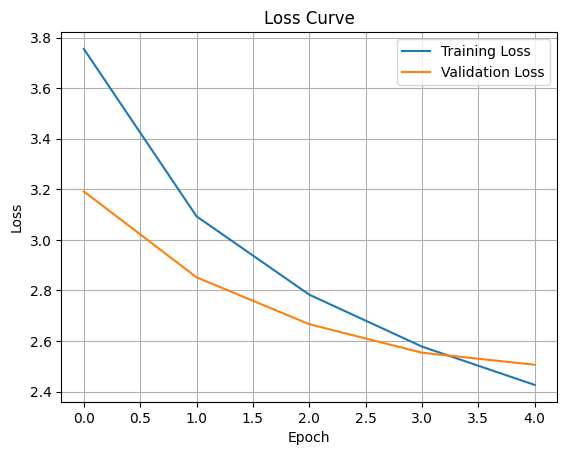

In [ ]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

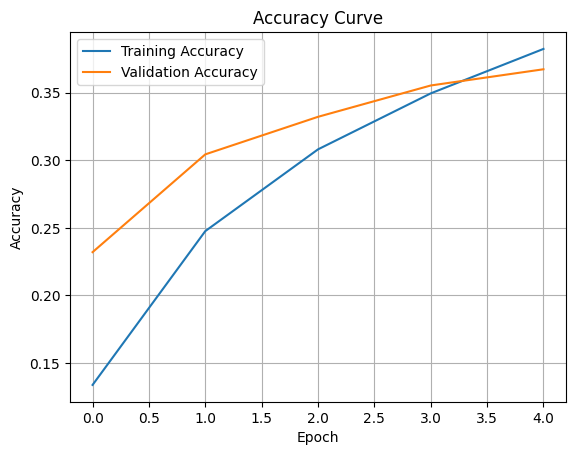

In [ ]:
# plotting accuracy...
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)
plt.show()

#### AttentionCNN Testing...

Test Accuracy: .1378

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST and get dataset info
train_loader, val_loader, test_loader, in_channels, image_size, num_classes = get_dataset("CIFAR100",batch_size=64)
criterion = nn.CrossEntropyLoss()

# Instantiate base feature extractor
base_model = BaseCNN(in_channels=in_channels).to(device)

print("Training Attention CNN...")
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []


iniTime = time.time()

att_model = AttentionCNN(base_model, feature_shape=(64, image_size // 4, image_size // 4), num_classes=num_classes).to(device)
att_optimizer = torch.optim.Adam(att_model.parameters(), lr=0.001)

for epoch in range(1, 6):
    tr_loss, tr_acc, val_loss, val_acc = train_one_epoch(att_model, train_loader, val_loader, att_optimizer, criterion, device)
    print(f"[AttCNN] Epoch {epoch}: Train Acc = {tr_acc:.4f}, Val Acc = {val_acc:.4f}")

    # for plotting...
    train_losses.append(tr_loss)
    val_losses.append(val_loss)

    train_accuracies.append(tr_acc)
    val_accuracies.append(val_acc)

test_loss, test_acc = evaluate(att_model, test_loader, criterion, device)
print(f"[AttCNN] Test Accuracy = {test_acc:.4f}")

finTime = time.time()
print(f"Total Time Taken: {finTime - iniTime}")

Files already downloaded and verified
Files already downloaded and verified
Training Attention CNN...
[AttCNN] Epoch 1: Train Acc = 0.0352, Val Acc = 0.0652
[AttCNN] Epoch 2: Train Acc = 0.0630, Val Acc = 0.0976
[AttCNN] Epoch 3: Train Acc = 0.0801, Val Acc = 0.1092
[AttCNN] Epoch 4: Train Acc = 0.0900, Val Acc = 0.1202
[AttCNN] Epoch 5: Train Acc = 0.0994, Val Acc = 0.1352
[AttCNN] Test Accuracy = 0.1378
Total Time Taken: 54.372740507125854


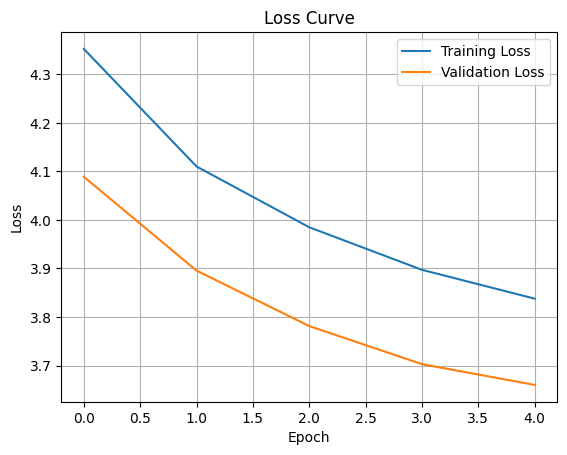

In [ ]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

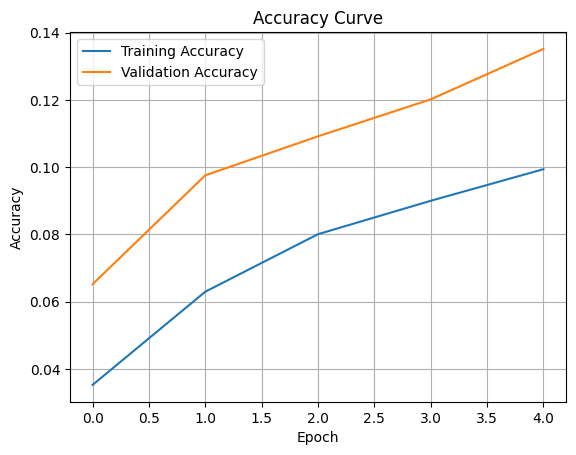

In [ ]:
# plotting accuracy...
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)
plt.show()

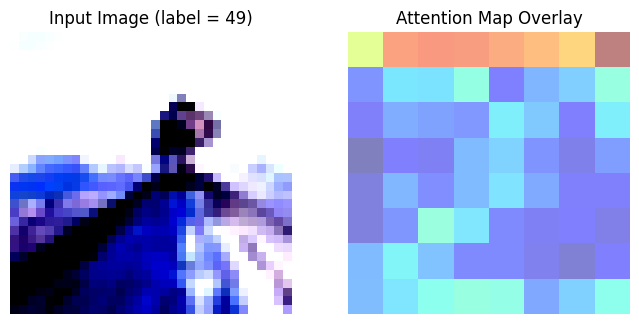

In [ ]:
# visualizing attention weights...
model = att_model

model.eval()
with torch.no_grad():
    sample_img, sample_label = test_loader.dataset[0]
    sample_tensor = sample_img.unsqueeze(0).to(device)
    # Get feature map from the base CNN
    feats = att_model.base_cnn(sample_tensor)
    B, C, H, W = feats.shape
    flat = feats.view(B, C, H * W) # [B, C, H*W]


    # calculating attention...
    if False:
        attn_scores = torch.ones(B, H * W, device=feats.device) # [B, H*W]
    else:
        attn_scores = flat.mean(dim=1)

    # Apply softmax to obtain normalized attention weights
    # Because all scores are equal, softmax will output uniform weights
    attn_weights = torch.softmax(attn_scores, dim=1) # [B, H*W]

    attn_map = attn_weights.view(H, W).cpu().numpy()
    # Normalize attention map for better visualization
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    # Plot input image
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    # this needs to be changed since we are now having 3 (rgb) input channels instead of 1 (grayscale) for mnist...
    ax[0].imshow(sample_img.clamp(0,1).permute(1,2,0).cpu(), cmap='gray')
    ax[0].set_title(f'Input Image (label = {sample_label})')
    ax[0].axis('off')
    # Plot attention map overlay
    ax[1].imshow(sample_img.clamp(0,1).permute(1,2,0).cpu(), cmap='gray')
    ax[1].imshow(attn_map, cmap='jet', alpha=0.5)
    ax[1].set_title('Attention Map Overlay')
    ax[1].axis('off')

## Analysis...

Answer the following questions in this markdown cell:

1. Did the attention mechanism improve your model’s performance or training speed compared to your original CNN? Why or why not?
2. What do your attention maps reveal about which parts of the images are most informative for classification?
3. After a certain point, neither model is particularly effective -- but we know that this is only a simple implementation now. What modifications could you make to the model structure (the layers in BaseCNN or AttentionCNN) to better make use of attention? And what modifications can we make to the attention mechanism itself to be more useful for classifying these images? Come up with at least three different methods.

1 \
Compared to the original CNN, the attention model was consistenly worse across all datasets.
Perhaps the reason why the AttentionCNN performed so much poorer than the original CNN is because
the attention mechanism used, just averaging the pixels across channels, is not a very good attention mechanism
to capture the complexity of the input. This explains why as we tested on more complex datasets (from MNIST to CIFAR),
the accuracy gap between original CNN and AttentionCNN got worse.

However, the training speed was higher for the attention model than the original, as observed
by testing with the CIFAR100. This is not surprising, especailly when we consider that the original
CNN is a lot more dense than the AttentionCNN. For example, the fc1 is C * H * W as input layer, while
the AttentionCNN is just C.


2 \
They highlight the most significant regions of image "blobs" in the input as well as ignore the background. That is,
where the average activation in the image is high.

3 \
One main idea that comes to mind right now is to implement the famous QKV attention. While I've dealt with this attention
for machine translation tasks, I'm curious what effect it would have to an image classification task. Right now, everything
is just spatial tokens, so I wonder if factoriing in positional encoding would make a difference.

For modifications to the BaseCNN, perhaps some hyperparameter tuning could yield better results, although I doubt they would
be anything significant. Some things that may be worth changing are nonlinear activation function (right now, it's only RELU)
as well as maybe try different optimizers for Gradient Descent.

Another thing could be in the BaseCNN, I could pool a lot less, so that there would be a higher spatial resolution to be used.
This may help with overall accuracy across both models, but computationally, it would be more expensive, since we now have more pixels
to consider, and so therefore, more matrix operations.


## Part 3: Extra credit

Try to see if you can implement improvements to your attention model. Are you able to outperform the baseline fully connected model ? You are allowed to edit either BaseCNN or AttentionCNN, but when testing you should use the same implementation of BaseCNN and FCClassifier.

You will recieve extra credit for any of the following:

- Up to +30 points: Implementations for improvements that allow AttentionCNN to outperform FCClassifier on any of the datasets.
- Up to +15 points: Implementations that successfully improve the AttentionCNN's performance, but have not resulted in AttentionCNN outperforming FCClassifier.
- Up to +5 points: Attempted implementation of AttentionCNN improvements

List any extra credit implementations you have attempted below, and which of the three categories they fall in.


In [ ]:
# Copy/paste AttentionCNN, BaseCNN, and FCClassifier below to modify if you are attempting extra credit:

In [ ]:
class FCClassifier(nn.Module):
    def __init__(self, base_cnn, feature_shape=(64, 14, 14),num_classes=10):
        super().__init__()
        self.base = base_cnn
        C, H, W = feature_shape
        self.fc1 = nn.Linear(C * H * W, 128)
        self.out = nn.Linear(128, num_classes)

    def forward(self, x):
        feats = self.base(x)                  # [B, C, H, W]
        flat = feats.view(x.size(0), -1)      # [B, C*H*W]
        x = F.relu(self.fc1(flat))
        return self.out(x)


In [ ]:
# import math

# class SimpleQKV(nn.Module):
#     def __init__(self, C, d=None):
#         super().__init__()
#         d = d or C
#         self.Wq = nn.Linear(C, d)
#         self.Wk = nn.Linear(C, d)
#         self.Wv = nn.Linear(C, d)
#         self.scale = math.sqrt(d)

#     def forward(self, tokens):  # [B, N, C]
#         Q, K, V = self.Wq(tokens), self.Wk(tokens), self.Wv(tokens)   # [B, N, d]
#         attn = torch.softmax(Q @ K.transpose(-2, -1) / self.scale, dim=-1)  # [B, N, N]
#         return attn @ V  # [B, N, d]

In [ ]:
# import math
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class AttentionCNN(nn.Module):
#     """
#     Self-attends over spatial tokens from a CNN feature map.
#     Base CNN must output [B, C, H, W].
#     """
#     def __init__(self, base_cnn, feature_shape, num_classes=10, d=None, attn_drop=0.1, p_drop=0.5):
#         super().__init__()
#         self.base_cnn = base_cnn

#         C, H, W = feature_shape
#         d = d or C                       # single head dim (keep =C for simplicity)

#         # Q, K, V projections (single head)
#         self.Wq = nn.Linear(C, d)
#         self.Wk = nn.Linear(C, d)
#         self.Wv = nn.Linear(C, d)
#         self.attn_dropout = nn.Dropout(attn_drop)

#         # (optional) tiny FFN on token space for a touch more capacity (comment to remove)
#         self.ffn = nn.Sequential(nn.Linear(d, 4*d), nn.GELU(), nn.Linear(4*d, d))
#         self.use_ffn = False             # flip to True if you want it

#         # classifier head (pooled dim = d)
#         self.fc1 = nn.Linear(d, 128)
#         self.dropout = nn.Dropout(p_drop)
#         self.out = nn.Linear(128, num_classes)

#     def forward(self, x):
#         feats = self.base_cnn(x)                       # [B, C, H, W]
#         B, C, H, W = feats.shape

#         # tokens = H*W spatial positions, each with C channels
#         tokens = feats.flatten(2).transpose(1, 2)      # [B, N, C], N=H*W

#         # project to Q, K, V
#         Q = self.Wq(tokens)                            # [B, N, d]
#         K = self.Wk(tokens)                            # [B, N, d]
#         V = self.Wv(tokens)                            # [B, N, d]

#         # scaled dot-product attention
#         scale = math.sqrt(Q.size(-1))
#         scores = torch.matmul(Q, K.transpose(-2, -1)) / scale   # [B, N, N]
#         weights = torch.softmax(scores, dim=-1)                 # [B, N, N]
#         weights = self.attn_dropout(weights)

#         attended = torch.matmul(weights, V)            # [B, N, d]

#         if self.use_ffn:
#             attended = attended + self.ffn(attended)   # tiny residual token MLP

#         # pool tokens to a single vector (mean is fine for MNIST)
#         pooled = attended.mean(dim=1)                  # [B, d]

#         z = F.relu(self.fc1(pooled))                   # [B, 128]
#         z = self.dropout(z)
#         logits = self.out(z)                           # [B, num_classes]

#         # return weights if you want to visualize attention maps
#         return logits


In [ ]:
# import math
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# # ---- 2D sine-cos positional encodings (ViT-style, no params) ----
# def build_2d_sincos_pos_embed(H, W, C, device):
#     assert C % 4 == 0, "C must be divisible by 4 for 2D sincos PE"
#     c = C // 4
#     y = torch.arange(H, device=device, dtype=torch.float32)
#     x = torch.arange(W, device=device, dtype=torch.float32)
#     wy = 1.0 / (10000 ** (torch.arange(c, device=device, dtype=torch.float32) / c))
#     wx = 1.0 / (10000 ** (torch.arange(c, device=device, dtype=torch.float32) / c))
#     yy = y[:, None] * wy[None, :]                    # [H, c]
#     xx = x[:, None] * wx[None, :]                    # [W, c]
#     pe_y = torch.cat([torch.sin(yy), torch.cos(yy)], dim=1)   # [H, 2c]
#     pe_x = torch.cat([torch.sin(xx), torch.cos(xx)], dim=1)   # [W, 2c]
#     pe_y = pe_y[:, None, :].repeat(1, W, 1)          # [H, W, 2c]
#     pe_x = pe_x[None, :, :].repeat(H, 1, 1)          # [H, W, 2c]
#     pe = torch.cat([pe_y, pe_x], dim=2)              # [H, W, 4c] = [H, W, C]
#     return pe.view(H*W, C)                           # [N, C]

# # ---- Transformer encoder block (MultiheadAttention + FFN) ----
# class EncoderBlock(nn.Module):
#     def __init__(self, dim, num_heads, attn_drop=0.1, proj_drop=0.1, ffn_ratio=4):
#         super().__init__()
#         self.ln1 = nn.LayerNorm(dim)
#         self.attn = nn.MultiheadAttention(dim, num_heads, dropout=attn_drop, batch_first=True)
#         self.drop_path = nn.Dropout(proj_drop)
#         self.ln2 = nn.LayerNorm(dim)
#         self.ffn = nn.Sequential(
#             nn.Linear(dim, ffn_ratio*dim),
#             nn.GELU(),
#             nn.Dropout(proj_drop),
#             nn.Linear(ffn_ratio*dim, dim),
#             nn.Dropout(proj_drop),
#         )
#         self._last_attn = None

#     def forward(self, x, need_weights=False):
#         # x: [B, N, C]
#         h = self.ln1(x)
#         attn_out, attn_w = self.attn(h, h, h, need_weights=need_weights, average_attn_weights=False)
#         if need_weights:
#             self._last_attn = attn_w  # [B, heads, N, N]
#         x = x + self.drop_path(attn_out)
#         x = x + self.ffn(self.ln2(x))
#         return x

#     def last_attn(self):
#         return self._last_attn

# # ---- Full model ----
# class AttentionCNN(nn.Module):
#     """
#     Multi-head self-attention on top of CNN features.
#     base_cnn must output [B, C, H, W]. We set embed_dim=C and heads | C.
#     """
#     def __init__(self, base_cnn, feature_shape, num_classes=10,
#                  num_heads=8, depth=2, attn_drop=0.1, proj_drop=0.1, cls_drop=0.5):
#         super().__init__()
#         self.base_cnn = base_cnn
#         C, H, W = feature_shape
#         assert C % num_heads == 0, "num_heads must divide channel dim C"

#         # positional encodings (fixed, not learned)
#         self.register_buffer("pos_embed", build_2d_sincos_pos_embed(H, W, C, device=torch.device("cpu")),
#                              persistent=False)  # moved to device on first forward
#         self.H, self.W, self.C = H, W, C

#         self.blocks = nn.ModuleList([
#             EncoderBlock(C, num_heads, attn_drop=attn_drop, proj_drop=proj_drop, ffn_ratio=4)
#             for _ in range(depth)
#         ])
#         self.norm = nn.LayerNorm(C)

#         # classifier head (token mean -> MLP)
#         self.fc1 = nn.Linear(C, 128)
#         self.dropout = nn.Dropout(cls_drop)
#         self.out = nn.Linear(128, num_classes)

#     @torch.no_grad()
#     def _pos(self, device):
#         if self.pos_embed.device != device:
#             self.pos_embed = self.pos_embed.to(device)
#         return self.pos_embed  # [N, C]

#     def forward(self, x, return_attn=False):
#         feats = self.base_cnn(x)                             # [B, C, H, W]
#         B, C, H, W = feats.shape
#         assert (C, H, W) == (self.C, self.H, self.W), f"Backbone shape changed: got {(C,H,W)}, expected {(self.C,self.H,self.W)}"

#         tokens = feats.flatten(2).transpose(1, 2)            # [B, N, C], N=H*W
#         pos = self._pos(tokens.device).unsqueeze(0)          # [1, N, C]
#         x = tokens + pos                                     # add position

#         # transformer encoder
#         for blk in self.blocks:
#             x = blk(x, need_weights=return_attn)

#         x = self.norm(x)
#         pooled = x.mean(dim=1)                               # [B, C]

#         z = F.relu(self.fc1(pooled))
#         z = self.dropout(z)
#         logits = self.out(z)

#         if return_attn:
#             # return attention from the last block
#             last_attn = self.blocks[-1].last_attn()          # [B, heads, N, N]
#             return logits, last_attn
#         return logits
